# Introduction

In this notebook, we'll evaluate classifiers performing forward and reverse inference using data from neuroimaging articles. *Forward inference* classifiers predict which brain structures were reported in activation coordinate data using the mental functions discussed in article texts. *Reverse inference* classifiers use the same data but flip the inputs and labels, predicting the mental functions in article texts from brain structures in the coordinate data. Classifiers were trained on 12,708 articles and will be evaluated on a test set of 1,816 articles. 

Classifiers are multilayer perceptrons implemented using the [SKLearn](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html) library. All classifiers were trained with 50 neurons per layer, a sigmoid activation function, and the Adam solver over 20 iterations. The learning rate (10<sup>-5,</sup>, 10<sup>-4</sup>, or 10<sup>-3</sup>) and number of hidden layers (1 or 2) were selected through 5-fold cross-validation on the training set. 

Evaluation metrics include the following:
1. **Area under the receiver operating characteristic curve (ROC-AUC)**, which captures the trade-off between true positive rate (TPR) and false positive rate (FPR).
2. **F1 score**, which captures the trade-off between precision and recall (the latter of which is equivalent to the TPR).



# Load the data

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
from evaluation import *
%matplotlib inline

In [2]:
framework = "data-driven"
suffix = ""
n_iter = 1000 # Number of iterations for bootstrap and null distributions
alphas = [0.01, 0.001, 0.0001] # Significance levels for plotting

## Brain activation coordinates

In [3]:
act_bin = load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=114


## Document-term matrix

In [4]:
dtm_bin = load_doc_term_matrix(version=190325, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Framework contents

In [5]:
lists, circuits = load_framework(framework, suffix=suffix)

## Term list scores

In [6]:
scores = score_lists(lists, dtm_bin)

# Load classifier fits

In [7]:
import pickle

In [8]:
directions = ["forward", "reverse"]

In [9]:
fit = {}
for direction in directions:
    fit[direction] = pickle.load(open("fits/{}_{}.p".format(
                                 framework, direction), "rb"), 
                                 encoding="latin1")
    print("-"*50 + "\n{} INFERENCE CLASSIFIER\n".format(direction.upper()) + "-"*50)
    print(fit[direction])
    print("")

--------------------------------------------------
FORWARD INFERENCE CLASSIFIER
--------------------------------------------------
OneVsRestClassifier(estimator=MLPClassifier(activation='logistic', alpha=1e-08, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=50, learning_rate='constant',
       learning_rate_init=0.001, max_iter=20, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=42, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False),
          n_jobs=1)

--------------------------------------------------
REVERSE INFERENCE CLASSIFIER
--------------------------------------------------
OneVsRestClassifier(estimator=MLPClassifier(activation='logistic', alpha=1e-08, batch_size='auto',
       beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50, 50), learning_rate='constant',
       learning_rate_init

## Test set

In [10]:
test = [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
print("Test N={}".format(len(test)))

Test N=1816


# Load the palette

In [11]:
palette = {"forward": [],
           "reverse": palettes[framework]}

In [12]:
domains = list(circuits.columns)
print(domains)

['MEMORY', 'REWARD', 'COGNITION', 'VISION', 'MANIPULATION', 'MEANING', 'LANGUAGE']


In [13]:
for structure in act_bin.columns:
    dom_idx = np.argmax(circuits.loc[structure].values)
    color = palette["reverse"][dom_idx]
    palette["forward"].append(color)

# Plot ROC and PR curves

## Forward inference

In [53]:
d = "forward"

### ROC curves

/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


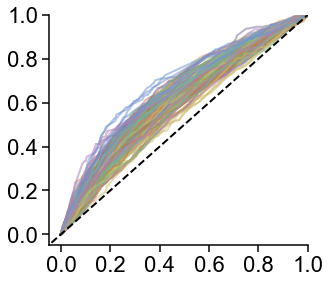

In [54]:
fpr, tpr = compute_roc(scores.loc[test], act_bin.loc[test], fit[d])
plot_curves("roc", framework, d, fpr, tpr, palette[d])

### PR curves

/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


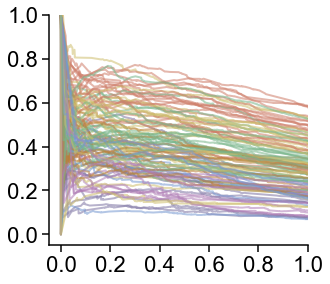

In [55]:
precision, recall = compute_prc(scores.loc[test], act_bin.loc[test], fit[d])
plot_curves("prc", framework, d, recall, precision, palette[d], diag=False)

## Reverse inference

In [56]:
d = "reverse"

### ROC curves

/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


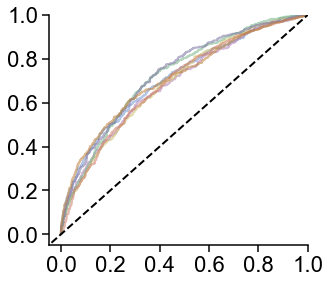

In [57]:
fpr, tpr = compute_roc(act_bin.loc[test], scores.loc[test], fit[d])
plot_curves("roc", framework, d, fpr, tpr, palette[d])

### PR curves

/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/matplotlib/figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


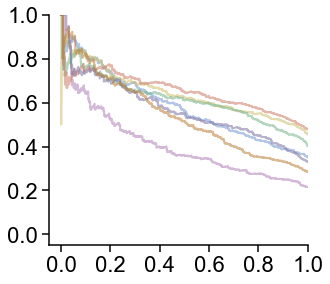

In [58]:
precision, recall = compute_prc(act_bin.loc[test], scores.loc[test], fit[d])
plot_curves("prc", framework, d, recall, precision, palette[d], diag=False)

# Compute evaluation metrics

## Observed values

In [20]:
metric_labels = ["rocauc", "f1"]
metric_functions = [roc_auc_score, f1_score]
X = {"forward": scores, "reverse": act_bin}
Y = {"forward": act_bin, "reverse": scores}

In [21]:
obs = {d: {} for d in directions}
for metric, function in zip(metric_labels, metric_functions):
    for d in directions:
        obs[d][metric] = compute_eval_metric(X[d].loc[test], Y[d].loc[test],
                                             fit[d], function)

/Users/ehbeam/anaconda/envs/ontol/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Bootstrap distributions

In [22]:
boot = {d: {} for d in directions}
for metric, function in zip(metric_labels, metric_functions):
    print("-"*20 + "\n" + metric.upper() + "\n" + "-"*20)
    for d in directions:
        print("{}".format(d.title()))
        boot[d][metric] = np.empty((len(obs[d][metric]), n_iter))
        for n in range(n_iter):
            samp = np.random.choice(test, size=len(test), replace=True)
            boot[d][metric][:,n] = compute_eval_metric(X[d].loc[samp], Y[d].loc[samp], 
                                                       fit[d], function)
            if n % (n_iter/10) == 0:
                print("\tIteration {}".format(n))
    print("")

--------------------
ROCAUC
--------------------
Forward
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900
Reverse
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900

--------------------
F1
--------------------
Forward
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900
Reverse
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900



## Null distributions

In [23]:
null = {d: {} for d in directions}
for metric, function in zip(metric_labels, metric_functions):
    print("-"*20 + "\n" + metric.upper() + "\n" + "-"*20)
    for d in directions:
        print("{}".format(d.title()))
        null[d][metric] = np.empty((len(obs[d][metric]), n_iter))
        for n in range(n_iter):
            shuf = np.random.choice(test, size=len(test), replace=False)
            null[d][metric][:,n] = compute_eval_metric(X[d].loc[test], Y[d].loc[shuf], 
                                                       fit[d], function)
            if n % (n_iter/10) == 0:
                print("\tIteration {}".format(n))
    print("")

--------------------
ROCAUC
--------------------
Forward
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900
Reverse
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900

--------------------
F1
--------------------
Forward
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900
Reverse
	Iteration 0
	Iteration 100
	Iteration 200
	Iteration 300
	Iteration 400
	Iteration 500
	Iteration 600
	Iteration 700
	Iteration 800
	Iteration 900



## Null confidence intervals

In [67]:
interval = 0.999
idx_lower = int((1.0-interval)*n_iter)
idx_upper = int(interval*n_iter)

In [68]:
null_ci = {d: {} for d in directions}
for metric in metric_labels:
    for d in directions:
        dist = null[d][metric]
        n_clf = dist.shape[0]
        null_ci[d][metric] = {}
        null_ci[d][metric]["lower"] = [sorted(dist[i,:])[idx_lower] for i in range(n_clf)]
        null_ci[d][metric]["upper"] = [sorted(dist[i,:])[idx_upper] for i in range(n_clf)]
        null_ci[d][metric]["mean"] = [np.mean(dist[i,:]) for i in range(n_clf)]

# Perform hypothesis testing

In [69]:
from statsmodels.stats.multitest import multipletests

In [70]:
p = {d: {} for d in directions}
for metric in metric_labels:
    for d in directions:
        dist = null[d][metric]
        n_clf = dist.shape[0]
        p[d][metric] = [np.sum(dist[i,:] >= obs[d][metric][i]) / float(n_iter) for i in range(n_clf)]

In [71]:
fdr = {d: {} for d in directions}
for metric in metric_labels:
    for d in directions:
        fdr[d][metric] = multipletests(p[d][metric], method="fdr_bh")[1]

# Plot evaluation metrics

## Forward inference

In [72]:
struct_labels = pd.read_csv("../data/brain/labels.csv", index_col=None)
struct_labels.index = struct_labels["PREPROCESSED"]
struct_labels = struct_labels.loc[act_bin.columns, "ABBREVIATION"].values

In [73]:
d = "forward"

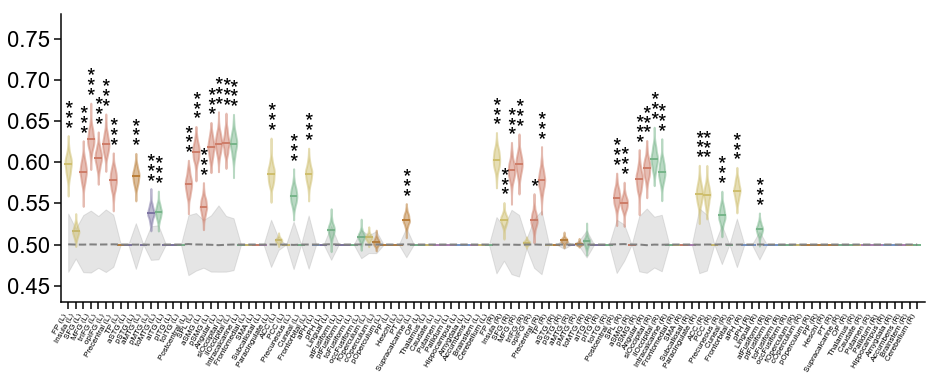

In [74]:
metric = "rocauc"
plot_eval_metric(metric, framework, d, obs[d][metric], 
                 boot[d][metric], null_ci[d][metric], fdr[d][metric],
                 palette[d], labels=struct_labels, dx=0.375, dxs=0.55,
                 figsize=(12, 4), ylim=[0.43, 0.78], alphas=alphas)

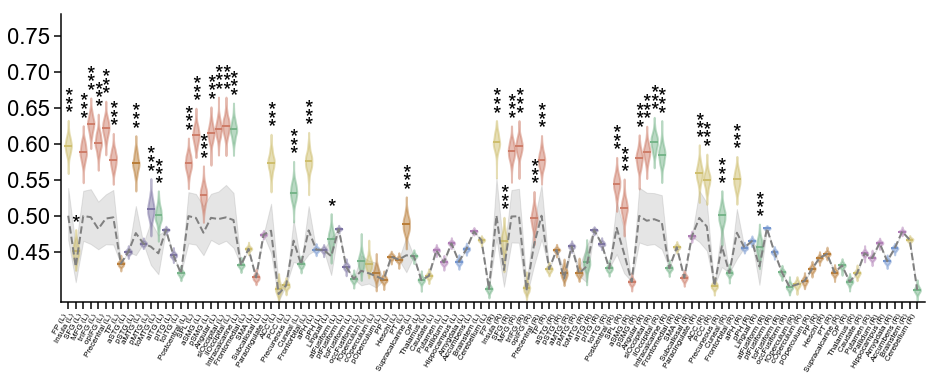

In [75]:
metric = "f1"
plot_eval_metric(metric, framework, d, obs[d][metric], 
                 boot[d][metric], null_ci[d][metric], fdr[d][metric],
                 palette[d], labels=struct_labels, dx=0.375, dxs=0.55,
                 figsize=(12, 4), ylim=[0.38, 0.78], alphas=alphas)

## Reverse inference

In [76]:
d = "reverse"

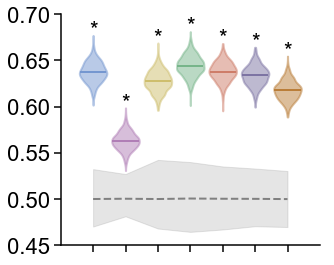

In [77]:
metric = "rocauc"
plot_eval_metric(metric, framework, d, obs[d][metric], 
                 boot[d][metric], null_ci[d][metric], fdr[d][metric],
                 palette[d], labels=[], dx=0.375, dxs=0.13, 
                 figsize=(3.6, 3.2), ylim=[0.45, 0.7], alphas=[0.01, 0, 0])

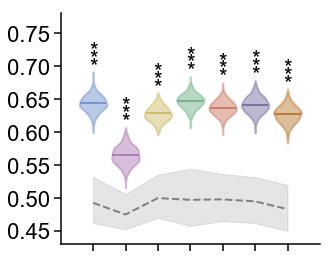

In [78]:
metric = "f1"
plot_eval_metric(metric, framework, d, obs[d][metric], 
                 boot[d][metric], null_ci[d][metric], fdr[d][metric],
                 palette[d], labels=[], dx=0.375, dxs=0.13, 
                 figsize=(3.6, 3.2), ylim=[0.43, 0.78], alphas=alphas)

# Export metric distributions

In [36]:
for metric in metric_labels:
    for d in directions:
        for dist, dic in zip(["boot", "null"], [boot, null]):
            df = pd.DataFrame(dic[d][metric], 
                              index=Y[d].columns, columns=range(n_iter))
            df.to_csv("data/{}_{}_{}_{}_{}iter.csv".format(
                metric, dist, framework, d, n_iter))